<a href="https://colab.research.google.com/github/azat1986/anekdots/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%B0%D0%BD%D0%B5%D0%BA%D0%B4%D0%BE%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация текста с помощью RNN


(по мотивам [семинара](https://github.com/neychev/harbour_dlia2019/blob/master/day02_Simple_RNN/Day_2_Simple_RNN_pytorch.ipynb)
 [курса "Deep Learning in Applications"](https://in.harbour.space/data-science/deep-learning-in-applications-radoslav-neychev-anastasia-ianina/))

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Данные
Датасет содержит ~130k анектодов на русском языке

In [3]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('anek.txt') as input_file:
    anek = input_file.read()[:-1].split('\n')
    anek = [' ' + line[:300] for line in anek]
    anek = [line.replace("\\n", " ") for line in anek]
    anek = [line.replace("\\\n", " ") for line in anek]
    anek = [line.replace("\\\\n", " ") for line in anek]

In [ ]:
anek[:5]

[' Из учебника физики за 8 класс под ред. С.В. Громова. Задача N109. В озеро упала ветка. Пробегавший мимо олень успел заметить что волна созданная падением ветки дошла до берега за 10 с причем расстояние между соседними гребнями волн было равно 10 см и за 2 с было 4 всплеска о берег. Помогите оленю определить как далеко от берега упала ветка. Интересно - что они курят?! ',
 ' В школе учитель спрашивает ученика: - Когда умер Александр Македонский? - Умер? Я даже не знал что он болен! ',
 ' Урок в одной из владивостокских школ обсуждается волнующая тема любовь и брак. Вопрос ученицы: А зачем нужны светящиеся презервативы? Ответил ученик очень тихий и застенчивый: Они освещают путь! ',
 ' Папа спрашивает у Вовочки: - Вовочка, что читаешь? - Учительница дала почитать, называется - Лесбиянки! - Да ну?!! А ну, дай посмотреть... Берет книгу, разочарованно: - А-а-а... Лес Бианки! ',
 ' Ребятишки слепили снеговик. Девочка:  У него кое-чего не хватает. Мальчик:  Я знаю. Сейчас принесу. Девочка:

Посмотрим на распределение длин анекдотов:

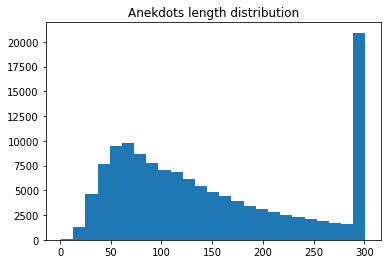

In [4]:
plt.title('Anekdots length distribution')
plt.hist(list(map(len, anek)), bins=25);

# Препроцессинг

In [5]:
#all unique characters go here
tokens = list(set(''.join(anek)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  211


### Символы -> id

Создадим словарь < символ > -> < id >

In [6]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [7]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [8]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of anekdots into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [9]:
#Example: cast 4 anekotds to matrices, pad with zeros
print('\n'.join(anek[::200]))
print(to_matrix(anek[::200], token_to_id))

 Из учебника физики за 8 класс под ред. С.В. Громова. Задача N109. В озеро упала ветка. Пробегавший мимо олень успел заметить что волна созданная падением ветки дошла до берега за 10 с причем расстояние между соседними гребнями волн было равно 10 см и за 2 с было 4 всплеска о берег. Помогите оленю о
 - Вы приговариваетесь к штрафу в пятьсот рублей. Надеюсь, это отучит вас обкрадывать телефоны - автоматы. - Понятно, гражданин судья. Скажите, а можно уплатить штраф двухкопеечными монетами? 
 Собрался парень на гулянку и говорит отцу: -Пап,если я пьяный номой приду ты ниче не делай уложи меня спать юююя просплюсь и всё нормально будет- и ушёл.На утро просыпается, смотрит а сам весь в синеках, ссадинах. ну непонимает что  случилось подходит к отцу с расспросами , а отец и отвечает: - Ну
 - Новые сигареты Беломорканал суперлёгкие... Надо иметь суперлёгкие, чтобы курить эти сигареты! 
 Встречаются во дворе два друга после очередной пьянки. Один другому говорит: - Меня жена как-то по-иностран

# Рекуррентные нейронные сети

<img src="https://github.com/Samsung-IT-Academy/stepik-dl-nlp/blob/master/img/rnn.png?raw=1" width=480>

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [11]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [12]:
char_rnn = CharRNNCell()

### Тренировка сети, RNN loop

In [13]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in anek_ix
    :param anek_ix: an int32 matrix of shape [batch, time], output of to_matrix(anek)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

### Тренировка сети

In [15]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

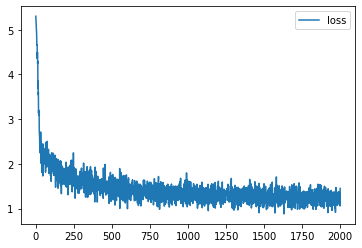

In [16]:
MAX_LENGTH = max(map(len, anek))

for i in range(2000):
    print (i)
    batch_ix = to_matrix(sample(anek, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    print (loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: генерация анектодов

In [17]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])        

In [18]:
for _ in range(10):
    print(generate_sample(char_rnn,temperature=0.8))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 B тать на спорасен.                                                                                                                                                                                                                                                                                         
 Вероб                                                                                                                                                                                                                                                                                                       
 Зазны ремупнактой кромит: - Мерочануть, болова коемя лостин рицится пружит в емго сомит:   Мешальнет: -Ма - прогокорошамезем                                                                                                                                                                                
 Мыхоректо, потора дорнывые зония одна себе сто сорусько в натри.                             

In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' Из'))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 Изналек всего дебующда и (silEthrr: Den_И - пнатала Бефама глагой павати, что хочцальбессолу со ракрнута:- Здейшfi- Дент бнего. обез давается.                                                                                                                                                              
 Изым чук  еслодка? Наку на рысколилание. Г тне, иссказивy залодящик ну чти бы увадай хфастсянта: - Сос вамарь, подало машу, задучет машенто а Паусов.                                                                                                                                                       
 Из_Empа. - Де кто пелл&quot;                                                                                                                                                                                                                                                                                
 Из тапа:- Тегу насподогча зходры прото сиваче росдали если в зКами хоростели …паго, :  - Да в

### Что еще можно генерировать?
С помощью кода из этого семинара можно генерировать не только имена, но и:

* Повести/романы/поэзию/песни любимого автора
* Новостные заголовки
* Программный код
* Молекулы в формате [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
* Музыку
* Названия мебели из ИКЕА
* Мотивационные лозунги
* etc.

__Удачи!__